# IMDB data set: opinions and recurrent neural networks

## Required imports

In [1]:
from collections import Counter
from keras.datasets import imdb
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pathlib import Path
import pickle

Using TensorFlow backend.


### Loading the data set

Load the data set, it will be downloaded and cached.

In [2]:
(x_train, y_train), (x_test, y_test) = imdb.load_data()

## Exploring the data set

### Data shape and types

Shape and type of the input and output.

In [3]:
x_train.shape, x_train.dtype, y_train.shape, y_train.dtype

((25000,), dtype('O'), (25000,), dtype('int64'))

In [4]:
x_test.shape, x_test.dtype, y_test.shape, y_test.dtype

((25000,), dtype('O'), (25000,), dtype('int64'))

Both training and test sets have 25,000 examples each.  The input is a list of integers, the output either 0 or 1.

In [5]:
type(x_train[0]), len(x_train[0]), type(x_train[0][0])

(list, 218, int)

In [6]:
set(y_train)

{0, 1}

Each training input consists of a list of integers.  Each integer uniquely represents a word, the list represents a text as an ordered sequence of words. The corresponding output is an integer, either 0 or 1, representing the opinion expressed in the review text.

### Review lengths

We can visualize the distribution of the review lengths in a histogram, one for the training, the other for the test input.

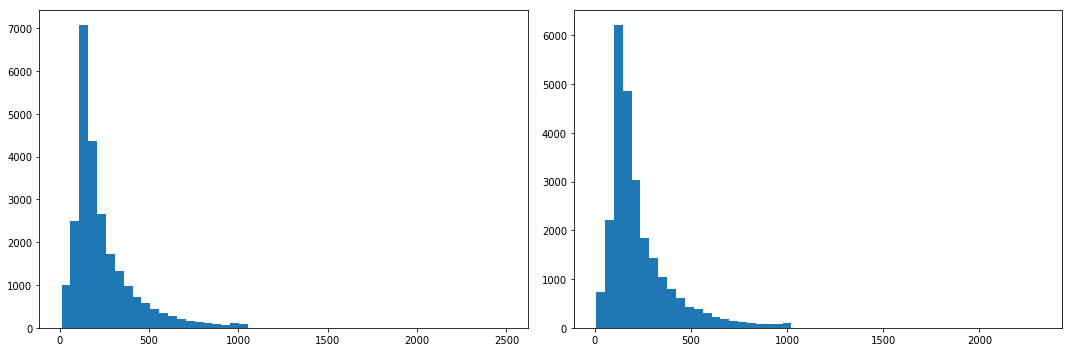

In [7]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i, reviews in enumerate((x_train, x_test)):
    review_lengths = map(len, reviews)
    axes[i].hist(list(review_lengths), bins=50);
figure.tight_layout()

### Word distribution

The distribution of the words, or features, can also be visualized.

The following computation is rather time consuming, so its results are pickled, so that they can be reused for demonstartion purposes without redoing the computation.

In [4]:
pickle_path = Path('feature_count.pkl')
if not pickle_path.exists():
    feature_counter = Counter()
    for review in x_train:
        for feature in review:
            feature_counter[feature] += 1
    with open('feature_count.pkl', 'wb') as pickle_file:
        pickle.dump(feature_counter, pickle_file)
else:
    with open('feature_count.pkl', 'rb') as pickle_file:
        feature_counter = pickle.load(pickle_file)

In [5]:
feature_counter.most_common(10)

[(4, 336148),
 (5, 164097),
 (6, 163040),
 (7, 145847),
 (8, 135708),
 (9, 107313),
 (10, 101871),
 (11, 93934),
 (12, 79058),
 (13, 77142)]

Note that the most common word starts at index 4, which may be unexpected.

In [6]:
feature_counter[0], feature_counter[1], feature_counter[2], feature_counter[3]

(0, 25000, 1, 0)

Index 0 serves as padding, 1 as start of a review (note that it occurs as many times as there are reviews in the training set).  For more details, see the section on texts below.

In [10]:
len(feature_counter)

88585

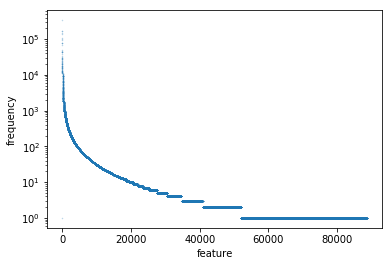

In [11]:
plt.semilogy(list(feature_counter.keys()), list(feature_counter.values()),
             '.', alpha=0.3, markersize=1)
plt.xlabel('feature')
plt.ylabel('frequency');

The features, i.e., the words, follow a Zipf-like distribution, which doesn't come as a surprise.  Since this computation is time consuming, we assume similar results for the test set.

Note that the minimum index is 1, the maximum 88586.

In [12]:
min(feature_counter.keys()), max(feature_counter.keys())

(1, 88586)

### Sentiment distribution

The distirbution of the opinions, 0 or 1, can be visualized in a bar plot, again one for the training, the other for the test output.

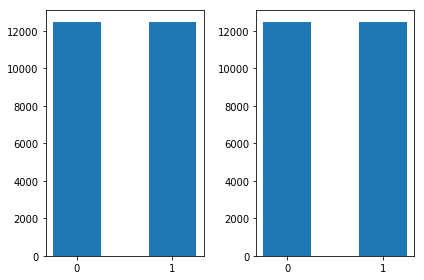

In [13]:
figure, axes = plt.subplots(1, 2)
for i, opinions in enumerate((y_train, y_test)):
    counter = [0, 0]
    for opinion in opinions:
        counter[opinion] += 1
    axes[i].bar(['0', '1'], counter, 0.5);
figure.tight_layout()

Positive and negetive opinions are uniformly distributed in the training set and the test set.

## Texts

The texts represented as a list of integers, each integer representing a specific word.  The word index, i.e, a dictionary that has the words as keys, and the integers as values is also available in the IMDB dataset.

In [7]:
word_index = imdb.get_word_index()

In [8]:
word_index['the']

1

However, in order to translate the lists of integers into the original reviews, the data has to be loaded appropriately.  The `load_data` method has some optional arguments that should be specified.  Index 0 is usually reserved for padding, i.e., to ensure that short sequences can be extended to the required length.  Index 1 indicates the start of a review (`start_char`), while index 2 is used to represent words that have not been indexed, either because they were not part of the data set, they were too infrequently used, or, if the top words are left out, too common to be considered informative (`oov_char`).  Hence, the actual word index starts at 4.

The word index has to be shifted by `index_from`, and the strings representing padding, start and unknown added.  The following function will do this, compute the reverse dictionary, and return both.

In [9]:
def compute_indices(word_index=None, index_from=3, padding_idx=0, start_idx=1, unknown_idx=2):
    if word_index is None:
        word_index = imdb.get_word_index()
    word_to_idx = {k: v + index_from for k, v in word_index.items()}
    word_to_idx['<pad>'] = padding_idx
    word_to_idx['<start>'] = start_idx
    word_to_idx['<unknown>'] = unknown_idx
    return word_to_idx, {v: k for k, v in word_to_idx.items()}

In [10]:
word_to_idx, idx_to_word = compute_indices(word_index)

The first review in the training set can now be "translated" back to English.  Note that there is no punctuation, and, since only the 1,000 most common words were loaded, quite a number of `<unknown>` crop up in the text.

In [11]:
print(' '.join(idx_to_word[idx] for idx in x_train[0]))

<start> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sho

The sentiment expressed in this review is positive, so the output should be 1.

In [3]:
y_train[0]

1

Find the first review expressing a negative sentiment.

In [6]:
neg_idx = list(y_train).index(0)

In [11]:
print(' '.join(idx_to_word[idx] for idx in x_train[neg_idx]))

<start> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their stomachs sickening that men actually wore them and the music is just synthesiser trash that plays over and over again in almost every scene there is trashy music boobs and paramedics taking away bodies and the gym still doesn't close for bereavement all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then


Clearly, the reviewer was not taken by the movie.

## Stop words

When you display the top-25 words, it is quite clear that most will not be very informative, except "but" at index 20 and "not" at index 23.

In [23]:
for i in range(4, 4 + 26):
    print(i, idx_to_word[i])

4 the
5 and
6 a
7 of
8 to
9 is
10 br
11 in
12 it
13 i
14 this
15 that
16 was
17 as
18 for
19 with
20 movie
21 but
22 film
23 on
24 not
25 you
26 are
27 his
28 have
29 he


It would most likely be fine to exclude all most frequent words upto "but", and limit the number of words to the 5,000 most frequent ones in order to reduce the dataset size, and hence the computations when training the network.

## Analyzing other texts

In [12]:
comments = open('comments.txt').readlines()

In [13]:
import re

In [14]:
def encode(comment, word_to_idx):
    words = re.findall(r'\w+', comment)
    words.insert(0, '<start>')
    return map(lambda x: word_to_idx[x] if x in word_to_idx else word_to_idx['<unknown>'], words)

In [15]:
num_unknowns = list()
lengths = list()
for comment in comments:
    words = list(encode(comment, word_to_idx))
    lengths.append(len(words))
    num_unknowns.append(words.count(2))

In [16]:
num_unknowns[:10]

[11, 34, 22, 3, 29, 8, 11, 2, 8, 22]

In [17]:
lengths[:10]

[43, 204, 138, 29, 143, 64, 66, 17, 48, 132]